# **BeDoZa protocol vs Not Privacy-Preserving Computation**




In [159]:
import numpy as np
import matplotlib.pyplot as plt
import time

n is a global variable:

In [160]:
n = 4
number_of_AND_gates = 21
number_of_layer = 0
layers = 14
number_of_curr_AND = 0
d = 0
e = 0

## Dealer's Class:

In [161]:
class Dealer:
  """
    param u: an array of random samples from {0,1}.
    param v: an array of random samples from {0,1}.
    param w: the result of u ⋅ v.
    param u_A: an array such that u = u_A ⨁ u_B.
    param v_A: an array such that v = v_A ⨁ v_B.
    param w_A: an array such that w = w_A ⨁ w_B.
    param u_B: an array such that u = u_A ⨁ u_B.
    param v_B: an array such that v = v_A ⨁ v_B.
    param w_B: an array such that w = w_A ⨁ w_B.
    param circuit: an array that represents a Boolean circuit.
  """
  
  def __init__(self):
    self.u = [np.random.randint(0,2) for i in range(number_of_AND_gates)]
    self.v = [np.random.randint(0,2) for i in range(number_of_AND_gates)]
    self.w = np.bitwise_and(self.u, self.v)

    self.u_A = [np.random.randint(0,2) for i in range(number_of_AND_gates)]
    self.v_A = [np.random.randint(0,2) for i in range(number_of_AND_gates)]
    self.w_A = [np.random.randint(0,2) for i in range(number_of_AND_gates)]

    self.u_B = np.bitwise_xor(self.u, self.u_A)
    self.v_B = np.bitwise_xor(self.v, self.v_A)
    self.w_B = np.bitwise_xor(self.w, self.w_A)

    """
    An array that represents a Boolean circuit as follows:
    each row i represents the ith layer in the circuit. Each member j in row i represents the j logical gate (from left to right) in layer i.
    define:
      Each logic gate is marked as follows: (g, i, wire1, wire2)
      When:
        - g is 0 if the gate is an xor and 1 if the gate is an and gate.
        - i is 1 if wire2 is a fixed number (c) and 0 otherwise.
        - wire1 is the index of the first wire (for the array of gate results from the previous layers) that enters the gate.
        - wire2 is the second wire of the gate: can be a fixed number (0 or 1) or the *index* of the second wire.
    """
    self.circuit = np.array([[(1,0,0,4), (1,0,0,5), (1,0,1,4), (1,0,1,5), (1,0,2,6), (1,0,2,7), (1,0,3,6), (1,0,3,7)],
                             [(0,1,0,0), (1,0,1,2), (0,0,1,2), (0,1,3,0), (0,1,4,0), (1,0,5,6), (0,0,5,6), (0,1,7,0)],
                             [(1,0,0,1), (0,0,0,1), (0,1,2,0), (0,1,3,0), (1,0,4,5), (0,0,4,5), (0,1,6,0), (0,1,7,0)],
                             [(1,0,0,4), (0,0,0,4), (1,0,1,5), (0,0,1,5), (1,0,2,6), (0,0,2,6), (1,0,3,7), (0,0,3,7)],
                             [(0,1,0,0), (0,1,1,0), (0,1,2,0), (0,1,3,0), (0,1,4,0), (1,0,5,6), (0,0,5,6), (0,1,7,0)],
                             [(0,1,0,0), (0,1,1,0), (0,1,2,0), (0,1,3,0), (0,0,4,5), (0,1,6,0), (0,1,7,0)],
                             [(0,1,0,0), (0,1,1,0), (0,1,2,0), (1,0,3,4), (0,0,3,4), (0,1,5,0), (0,1,6,0)],
                             [(0,1,0,0), (0,1,1,0), (0,0,2,3), (0,1,4,0), (0,1,5,0), (0,1,6,0)],
                             [(0,1,0,0), (1,0,1,2), (0,0,1,2), (0,1,3,0), (0,1,4,0), (0,1,5,0)],
                             [(0,0,0,1), (0,1,2,0), (0,1,3,0), (0,1,4,0), (0,1,5,0)],
                             [(1,0,0,1), (0,0,0,1), (0,1,2,0)],
                             [(0,0,0,1), (0,1,2,0)],
                             [(1,0,0,1), (0,0,0,1)],
                             [(0,0,0,1)]], dtype=object)
      
  def RandA(self):
    """
      Returns:
      - circuit: the Boolean circuit of the function.
      - u_A: an array such that u = u_A ⨁ u_B.
      - v_A: an array such that v = v_A ⨁ v_B.
      - w_A: an array such that w = w_A ⨁ w_B.
    """
    return self.circuit, self.u_A, self.v_A, self.w_A

  def RandB(self):
    """
      Returns:
      - u_B: an array such that u = u_A ⨁ u_B.
      - v_B: an array such that v = v_A ⨁ v_B.
      - w_B: an array such that w = w_A ⨁ w_B.
    """
    return self.circuit, self.u_B, self.v_B, self.w_B

## Alice's Class:

In [162]:
class Alice:
  """
    param x: Alice's input.
    param circuit: an array that represents a Boolean circuit.
    param A: Alice's array of inputs after Alice and Bob share their input wires.
    param u_A: an array of random samples from {0,1}.
    param v_A: an array of random samples from {0,1}.
    param w_A: an array of random samples from {0,1}.
    param i: a temporary array that holds indexes. 
    param z_B: an array that Bob sends to Alice.
  """

  def __init__(self, x, circuit, u_A, v_A, w_A):
    self.x = x
    self.circuit = circuit

    self.A = np.zeros((2*n), dtype=int)
    for i in range(n):
      self.A[i] = np.random.randint(0,2)
    
    self.u_A = u_A
    self.v_A = v_A
    self.w_A = w_A

    self.i = -1
    self.z_B = -1

  def ReceiveY_A(self, y_A):
    """
      param y_A: an array such that (y_A, y_B) <- Share(B, y).
    """
    for i in range(n,2*n):
      self.A[i] = y_A[i - 2*n]

  def SendX_B(self):
    """
      Returns:
      - x_B: an array such that (x_A, x_B) <- Share(A, x).
    """
    x_B = np.zeros((n), dtype=int)
    for i in range(0,n):
      x_B[i] = np.bitwise_xor(self.x[i], self.A[i])
    return x_B

  def Receive(self, z_B):
    """
      param z_B: an array of the results of the gates (of Bob) that Bob computes and Alice receives from him.
    """
    global number_of_layer
    global number_of_curr_AND
    global d, e

    self.z_B = z_B
    
    for idx in range(len(self.circuit[number_of_layer])):
      if self.i[idx] != -1:
        number_of_current_AND = self.A[self.i[idx]][2]
        r1 = np.bitwise_xor(self.w_A[number_of_current_AND], np.bitwise_and(e[self.i[idx]], np.bitwise_xor(self.A[self.i[idx]][0], self.u_A[number_of_current_AND])))
        r2 = np.bitwise_and(d[self.i[idx]], np.bitwise_xor(self.A[self.i[idx]][1], self.v_A[number_of_current_AND]))
        self.A[self.i[idx]] = np.bitwise_xor(r1, r2)
        d[self.i[idx]] = -1
        e[self.i[idx]] = -1
        self.i[idx] = -1
    number_of_layer += 1

  def Send(self):
    """
      param z_A: a temporary array of the results of the gates (of Alice) that Alice computes and sends to Bob.
      Returns:
      - ANDS: an array such that ANDS[i] = [x_A ⨁ u_A, y_A ⨁ v_A, #AND].
    """
    global number_of_curr_AND
    z_A = [0 for i in range(len(self.circuit[number_of_layer]))]
    ANDS = [-1 for i in range(len(self.circuit[number_of_layer]))]
    self.i = [-1 for i in range(len(self.circuit[number_of_layer]))]
    idx = 0
    for i in range(len(self.circuit[number_of_layer])):
      if self.circuit[number_of_layer][i][0] == 0:      # XOR
        if self.circuit[number_of_layer][i][1] == 0:    # XOR([x],[y])
          z_A[i] = np.bitwise_xor(self.A[self.circuit[number_of_layer][i][2]], self.A[self.circuit[number_of_layer][i][3]])
        else:                                           # XOR([x],c)
          z_A[i] = np.bitwise_xor(self.A[self.circuit[number_of_layer][i][2]], self.circuit[number_of_layer][i][3])
      
      else:                                             # AND
        if self.circuit[number_of_layer][i][1] == 0:    # AND([x],[y])
          self.i[idx] = i
          idx += 1
          z_A[i] = [np.bitwise_xor(self.A[self.circuit[number_of_layer][i][2]], self.u_A[number_of_curr_AND]), np.bitwise_xor(self.A[self.circuit[number_of_layer][i][3]], self.v_A[number_of_curr_AND]), number_of_curr_AND]
          ANDS[i] = z_A[i]
          number_of_curr_AND += 1       
        else: # AND([x],c)
          z_A[i] = np.bitwise_and(self.A[self.circuit[number_of_layer][i][2]], self.circuit[number_of_layer][i][3])
    self.A = z_A
    return ANDS

  def hasOutput(self):
    """
      Returns:
        - True/False: a Boolean value indicating whether Alice has input.
    """
    if  number_of_layer < layers:
      return False
    return True

  def Output(self):
    """
      Returns:
      - z: Alice's output.
    """
    return np.bitwise_xor(self.z_B[0], self.A[0])

## Bob's Class:

In [163]:
class Bob:
  """
    param y: Bob's input.
    param circuit: an array that represents a Boolean circuit.
    param B: Bob's array of inputs after Alice and Bob share their input wires.
    param u_B: an array of random samples from {0,1}.
    param v_B: an array of random samples from {0,1}.
    param w_B: an array of random samples from {0,1}.
  """
  
  def __init__(self, y, circuit, u_B, v_B, w_B):
    self.y = y
    self.circuit = circuit
    self.B = np.zeros((2*n), dtype=int)
    self.u_B = u_B
    self.v_B = v_B
    self.w_B = w_B


  def ReceiveX_B(self, x_B):
    """
      param x_B: an array such that (x_A, x_B) <- Share(A, x).
    """
    for i in range(0,n):
      self.B[i] = x_B[i]
  
  def SendY_A(self):
    """
      Returns:
      - y_A: an array such that (y_A, y_B) <- Share(B, y).
    """
    y_A = np.zeros((n), dtype=int)
    for i in range(n,2*n):
      self.B[i] = np.random.randint(0,2)
      y_A[i - n] = np.bitwise_xor(self.y[i - n], self.B[i])
    return y_A

  def Receive(self, ANDS):
    """
      param ANDS: an array such that ANDS[i] = [x_A ⨁ u_A, y_A ⨁ v_A, #AND].
    """
    global d, e
    z_B = [0 for i in range(len(self.circuit[number_of_layer]))]
    d = [-1 for i in range(len(self.circuit[number_of_layer]))]
    e = [-1 for i in range(len(self.circuit[number_of_layer]))]
    for i in range(len(self.circuit[number_of_layer])):
      if self.circuit[number_of_layer][i][0] == 0:         # XOR
        if self.circuit[number_of_layer][i][1] == 0: # XOR([x],[y])
          z_B[i] = np.bitwise_xor(self.B[self.circuit[number_of_layer][i][2]], self.B[self.circuit[number_of_layer][i][3]])
        else: # XOR([x],c)
          z_B[i] = self.B[self.circuit[number_of_layer][i][2]]
      else:                                                 # AND
        if self.circuit[number_of_layer][i][1] == 0: # AND([x],[y])
          number_of_current_AND = ANDS[i][2]
          d[i] = np.bitwise_xor(ANDS[i][0], np.bitwise_xor(self.B[self.circuit[number_of_layer][i][2]], self.u_B[number_of_current_AND]))
          e[i] = np.bitwise_xor(ANDS[i][1], np.bitwise_xor(self.B[self.circuit[number_of_layer][i][3]], self.v_B[number_of_current_AND]))
          r1 = np.bitwise_xor(self.w_B[number_of_current_AND], np.bitwise_and(e[i], self.B[self.circuit[number_of_layer][i][2]]))
          r2 = np.bitwise_xor(np.bitwise_and(d[i], self.B[self.circuit[number_of_layer][i][3]]), np.bitwise_and(e[i], d[i]))
          z_B[i] = np.bitwise_xor(r1, r2)
        else: # AND([x],c)
          z_B[i] = np.bitwise_and(self.B[self.circuit[number_of_layer][i][2]], self.circuit[number_of_layer][i][2])
    self.B = z_B

  def Send(self):
    """
      Returns:
      - z_B: an array of the results of the gates (of Bob) that Bob computes and sends to Alice.
    """
    z_B = self.B
    return z_B

In [164]:
def plot(pp_time, npp_time):
  plt.figure(figsize=(20, 5))
  plt.scatter(range(len(pp_time)),pp_time, label='privacy-preserving', s=50, color='#00FF00', alpha=0.5)
  plt.scatter(range(len(npp_time)),npp_time, label='not privacy-preserving', s=10, color='#FF3131', alpha=1)
  plt.xlabel('input (x_1,x_2,a_1,a_2)')
  plt.ylabel('time per execution')
  plt.legend()
  
  plt.show()

In [165]:
vec_a = [[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0],[0,0,1,1],[0,1,0,1],[1,0,0,1],[0,1,1,0],[1,0,1,0],[1,1,0,0],[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0],[1,1,1,1]]
vec_x = [[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0],[0,0,1,1],[0,1,0,1],[1,0,0,1],[0,1,1,0],[1,0,1,0],[1,1,0,0],[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0],[1,1,1,1]]

## **privacy-preserving computation:**

In [166]:
pp_z = np.zeros((n**2)*(n**2), dtype=int)
idx = 0
pp_time = np.zeros((n**2)*(n**2), dtype=float)
for i in range(len(vec_x)):
  for j in range(len(vec_a)):
    pp_time[idx] = time.time()
    n = 4
    number_of_AND_gates = 21
    number_of_layer = 0
    layers = 14
    number_of_curr_AND = 0
    d = 0
    e = 0
    dealer = Dealer()
    circuit_A, u_A, v_A, w_A = dealer.RandA()
    circuit_B, u_B, v_B, w_B = dealer.RandB()
    alice = Alice(x=vec_x[i], circuit=circuit_A, u_A=u_A, v_A=v_A, w_A=w_A)
    bob = Bob(y=vec_a[j], circuit=circuit_B, u_B=u_B, v_B=v_B, w_B=w_B)
    bob.ReceiveX_B(x_B=alice.SendX_B())
    alice.ReceiveY_A(y_A=bob.SendY_A())
    while alice.hasOutput() == False:
      ANDS = alice.Send()
      bob.Receive(ANDS=ANDS)
      z_B = bob.Send()
      alice.Receive(z_B=z_B)
    pp_z[idx] = alice.Output()
    pp_time[idx] = time.time() - pp_time[idx]
    idx = idx + 1

## **Not privacy-preserving computation:**

In [167]:
npp_z = np.zeros((n**2)*(n**2), dtype=int)
idx = 0
npp_time = np.zeros((n**2)*(n**2), dtype=float)
for i in range(len(vec_x)):
  for j in range(len(vec_a)):
    npp_time[idx] = time.time()
    x_1 = vec_x[i][0] * 2 + vec_x[i][1] * 1
    x_2 = vec_x[i][2] * 2 + vec_x[i][3] * 1
    a_1 = vec_a[j][0] * 2 + vec_a[j][1] * 1
    a_2 = vec_a[j][2] * 2 + vec_a[j][3] * 1
    if (a_1*x_1 + a_2*x_2) >= 4:
      npp_z[idx] = 1
    else:
      npp_z[idx] = 0
    npp_time[idx] = time.time() - npp_time[idx]
    idx = idx + 1

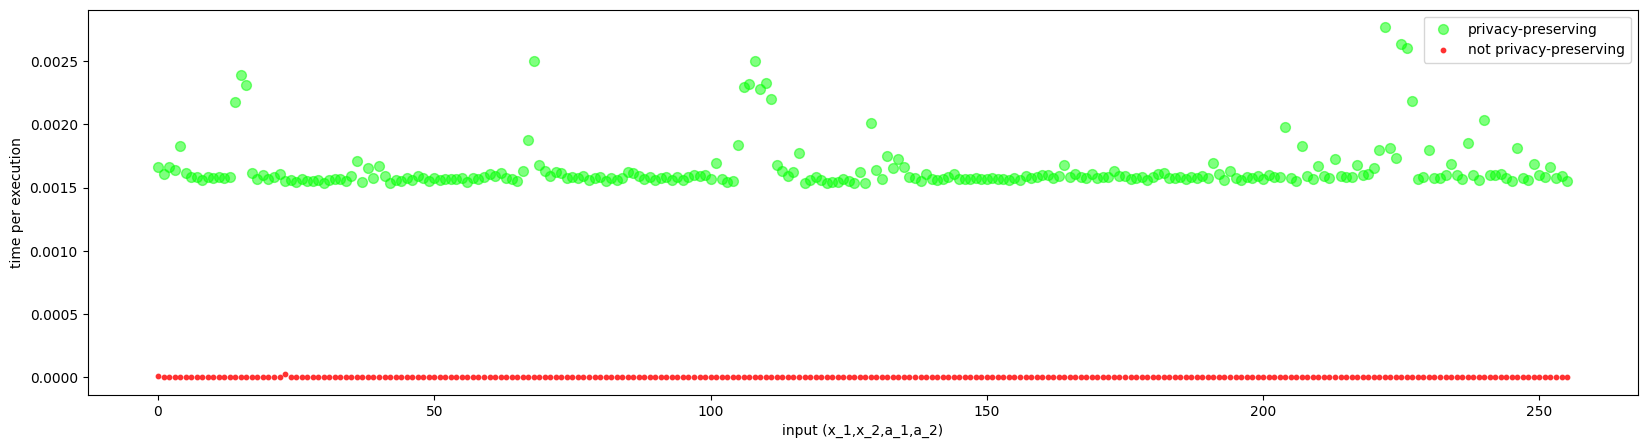

In [168]:
plot(pp_time, npp_time)